# Loading in CIFER-10 for training


In [ ]:
import os
import sys
import time
import random

import numpy as np
import pandas as pd
from scipy import linalg
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.utils.data
from torch.nn.functional import adaptive_avg_pool2d

import torchvision
from torchvision import datasets, transforms, models, utils
import torchvision.datasets as dset

import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

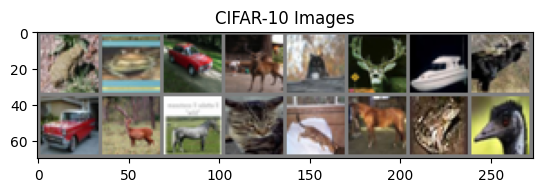

frog frog automobile deer cat deer ship deer automobile deer horse cat cat horse frog bird


In [8]:
trainset = torchvision.datasets.CIFAR10(root='/kaggle/working', train=True, download=True, transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]))
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True)

testset = torchvision.datasets.CIFAR10(root='/kaggle/working', train=False, download=True, transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]))
testloader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=True)

images, labels = next(iter(trainloader))
images = images[:16]
labels = labels[:16]
plt.imshow(torchvision.utils.make_grid(images).permute(1, 2, 0) / 2 + 0.5); 
plt.title("CIFAR-10 Images"); plt.show()
print(' '.join(trainset.classes[label] for label in labels))

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# GAN


## Architecture


In [10]:
# Hyperparams

latent_dim = 256
lr = 0.0001
beta1 = 0.5
beta2 = 0.999
num_epochs = 50

In [23]:
class Generator(nn.Module):
    def __init__(self, latent_dim=128):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 1024 * 4 * 4),
            nn.Unflatten(1, (1024, 4, 4)),
        
            nn.ConvTranspose2d(1024, 512, 4, 2, 1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
        
            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
        
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
        
            nn.ConvTranspose2d(128, 3, 3, 1, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, z):
        return self.model(z)

In [12]:
import torch.nn as nn
from torch.nn.utils import spectral_norm

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            spectral_norm(nn.Conv2d(3, 64, 4, 2, 1, bias=False)),
            nn.LeakyReLU(0.2, inplace=True),

            spectral_norm(nn.Conv2d(64, 128, 4, 2, 1, bias=False)),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),

            spectral_norm(nn.Conv2d(128, 256, 4, 2, 1, bias=False)),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),

            spectral_norm(nn.Conv2d(256, 512, 4, 2, 1, bias=False)),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(512, 1, 2, 1, 0, bias=False)
        )

    def forward(self, img):
        return self.model(img).view(-1, 1)

In [13]:
def weights_init(m):
    '''
    Initialize all conv layers with mean=0, stdev=0.02
    Init all batchnorm layers w mean=1.0, stdev=0.02
    '''
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

# Loading in pretrained Resnet-50 for classification later on

Loaded from here: https://www.kaggle.com/code/firuzjuraev/usage-of-trained-models

## Three functions

The important one for us is just `class_distribution(images)`
This takes images in range (-1,1) - just how we transform it and how gan outputs it, and returns a dict with keys classes and values the number identified. I'll use it to classify diversity for my GAN n VAE. The model has a one shot accuracy of 94%


In [14]:
cifar10_classes = (
    'plane', 'car', 'bird', 'cat', 'deer',
    'dog', 'frog', 'horse', 'ship', 'truck'
)

# ================================
# Normalization
# ================================
cifar10_mean = (0.4914, 0.4822, 0.4465)
cifar10_std = (0.2023, 0.1994, 0.2010)

transform_cifar = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(cifar10_mean, cifar10_std),
])


# ================================
# Load pretrained classifier
# ================================
classifier = torch.hub.load("chenyaofo/pytorch-cifar-models", 
                            "cifar10_resnet56", pretrained=True)

classifier = classifier.to(device).eval()

# ================================
# Helper functions
# ================================
# 1. Predict single image
def predict_image(img):
    """
    img: torch.Tensor shape [3,H,W] in range [0,1] (unnormalized)
    returns: class name (str)
    """
    # Normalize for CIFAR-10 pretrained model
    transform = transforms.Normalize(cifar10_mean, cifar10_std)
    img = transform(img).unsqueeze(0).to(device)
    with torch.no_grad():
        outputs = classifier(img)
        _, pred = outputs.max(1)
    return cifar10_classes[pred.item()]

# 2. Evaluate accuracy on loader
def evaluate_accuracy(loader):
    """
    loader: DataLoader with (images, labels)
    returns: accuracy in %
    """
    correct, total = 0, 0
    classifier.eval()
    with torch.no_grad():
        for images, labels in loader:
            # images are in [-1,1], map back to [0,1]
            imgs = (images + 1.0) / 2.0
            # Normalize for CIFAR-10 pretrained model
            transform = transforms.Normalize(cifar10_mean, cifar10_std)
            imgs = torch.stack([transform(img) for img in imgs]).to(device)
            labels = labels.to(device)
        
            outputs = classifier(imgs)
            _, preds = outputs.max(1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    return 100.0 * correct / total

# 3. Class distribution counter
def class_distribution(images):
    """
    images: torch.Tensor [B,3,H,W] in range [-1,1] (GAN output)
    returns: dict {class_name: count}
    """
    # GAN images are in [-1,1], map back to [0,1]
    imgs = (images + 1.0) / 2.0
    # Normalize for CIFAR-10 pretrained model
    transform = transforms.Normalize(cifar10_mean, cifar10_std)
    imgs = torch.stack([transform(img) for img in imgs]).to(device)

    counts = {cls: 0 for cls in cifar10_classes}
    classifier.eval()
    with torch.no_grad():
        outputs = classifier(imgs)
        preds = outputs.argmax(dim=1)
        for p in preds.cpu().numpy():
            counts[cifar10_classes[p]] += 1
    return counts

# Check accuracy on testset
acc = evaluate_accuracy(testloader)
print(f"Test accuracy: {acc:.2f}%")

# Check GAN distribution (example, replace with your fake images)
# fake_images = generator(torch.randn(64, latent_dim, 1, 1, device=device))
# dist = class_distribution(fake_images)
# print(dist)

/usr/local/lib/python3.11/dist-packages/torch/hub.py:330: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/chenyaofo/pytorch-cifar-models/zipball/master" to /root/.cache/torch/hub/master.zip
Downloading: "https://github.com/chenyaofo/pytorch-cifar-models/releases/download/resnet/cifar10_resnet56-187c023a.pt" to /root/.cache/torch/hub/checkpoints/cifar10_resnet56-187c023a.pt
100%|██████████| 3.39M/3.39M [00:00<00:00, 70.2MB/s

Test accuracy: 94.37%


# Loading in FID, implementation taken from this amazing notebook, that in turn took it from Pytorch's official FID implementation

Notebook: https://www.kaggle.com/code/ibtesama/gan-in-pytorch-with-fid


In [15]:
class InceptionV3(nn.Module):
    """Pretrained InceptionV3 network returning feature maps"""

    # Index of default block of inception to return,
    # corresponds to output of final average pooling
    DEFAULT_BLOCK_INDEX = 3

    # Maps feature dimensionality to their output blocks indices
    BLOCK_INDEX_BY_DIM = {
        64: 0,   # First max pooling features
        192: 1,  # Second max pooling featurs
        768: 2,  # Pre-aux classifier features
        2048: 3  # Final average pooling features
    }

    def __init__(self,
                 output_blocks=[DEFAULT_BLOCK_INDEX],
                 resize_input=True,
                 normalize_input=True,
                 requires_grad=False):
        
        super(InceptionV3, self).__init__()

        self.resize_input = resize_input
        self.normalize_input = normalize_input
        self.output_blocks = sorted(output_blocks)
        self.last_needed_block = max(output_blocks)

        assert self.last_needed_block <= 3, \
            'Last possible output block index is 3'

        self.blocks = nn.ModuleList()

        
        inception = models.inception_v3(pretrained=True)

        # Block 0: input to maxpool1
        block0 = [
            inception.Conv2d_1a_3x3,
            inception.Conv2d_2a_3x3,
            inception.Conv2d_2b_3x3,
            nn.MaxPool2d(kernel_size=3, stride=2)
        ]
        self.blocks.append(nn.Sequential(*block0))

        # Block 1: maxpool1 to maxpool2
        if self.last_needed_block >= 1:
            block1 = [
                inception.Conv2d_3b_1x1,
                inception.Conv2d_4a_3x3,
                nn.MaxPool2d(kernel_size=3, stride=2)
            ]
            self.blocks.append(nn.Sequential(*block1))

        # Block 2: maxpool2 to aux classifier
        if self.last_needed_block >= 2:
            block2 = [
                inception.Mixed_5b,
                inception.Mixed_5c,
                inception.Mixed_5d,
                inception.Mixed_6a,
                inception.Mixed_6b,
                inception.Mixed_6c,
                inception.Mixed_6d,
                inception.Mixed_6e,
            ]
            self.blocks.append(nn.Sequential(*block2))

        # Block 3: aux classifier to final avgpool
        if self.last_needed_block >= 3:
            block3 = [
                inception.Mixed_7a,
                inception.Mixed_7b,
                inception.Mixed_7c,
                nn.AdaptiveAvgPool2d(output_size=(1, 1))
            ]
            self.blocks.append(nn.Sequential(*block3))

        for param in self.parameters():
            param.requires_grad = requires_grad

    def forward(self, inp):
        """Get Inception feature maps
        Parameters
        ----------
        inp : torch.autograd.Variable
            Input tensor of shape Bx3xHxW. Values are expected to be in
            range (0, 1)
        Returns
        -------
        List of torch.autograd.Variable, corresponding to the selected output
        block, sorted ascending by index
        """
        outp = []
        x = inp

        if self.resize_input:
            x = F.interpolate(x,
                              size=(299, 299),
                              mode='bilinear',
                              align_corners=False)

        if self.normalize_input:
            x = 2 * x - 1  # Scale from range (0, 1) to range (-1, 1)

        for idx, block in enumerate(self.blocks):
            x = block(x)
            if idx in self.output_blocks:
                outp.append(x)

            if idx == self.last_needed_block:
                break

        return outp
    
block_idx = InceptionV3.BLOCK_INDEX_BY_DIM[2048]
model = InceptionV3([block_idx])
model=model.cuda()

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth
100%|██████████| 104M/104M [00:00<00:00, 206MB/s] 


In [16]:
def calculate_activation_statistics(images,model,batch_size=128, dims=2048,
                    cuda=False):
    model.eval()
    act=np.empty((len(images), dims))
    
    if cuda:
        batch=images.cuda()
    else:
        batch=images
    pred = model(batch)[0]

        # If model output is not scalar, apply global spatial average pooling.
        # This happens if you choose a dimensionality not equal 2048.
    if pred.size(2) != 1 or pred.size(3) != 1:
        pred = adaptive_avg_pool2d(pred, output_size=(1, 1))

    act= pred.cpu().data.numpy().reshape(pred.size(0), -1)
    
    mu = np.mean(act, axis=0)
    sigma = np.cov(act, rowvar=False)
    return mu, sigma

In [17]:
def calculate_frechet_distance(mu1, sigma1, mu2, sigma2, eps=1e-6):
    """Numpy implementation of the Frechet Distance.
    The Frechet distance between two multivariate Gaussians X_1 ~ N(mu_1, C_1)
    and X_2 ~ N(mu_2, C_2) is
            d^2 = ||mu_1 - mu_2||^2 + Tr(C_1 + C_2 - 2*sqrt(C_1*C_2)).
    """

    mu1 = np.atleast_1d(mu1)
    mu2 = np.atleast_1d(mu2)

    sigma1 = np.atleast_2d(sigma1)
    sigma2 = np.atleast_2d(sigma2)

    assert mu1.shape == mu2.shape, \
        'Training and test mean vectors have different lengths'
    assert sigma1.shape == sigma2.shape, \
        'Training and test covariances have different dimensions'

    diff = mu1 - mu2

    
    covmean, _ = linalg.sqrtm(sigma1.dot(sigma2), disp=False)
    if not np.isfinite(covmean).all():
        msg = ('fid calculation produces singular product; '
               'adding %s to diagonal of cov estimates') % eps
        print(msg)
        offset = np.eye(sigma1.shape[0]) * eps
        covmean = linalg.sqrtm((sigma1 + offset).dot(sigma2 + offset))

    
    if np.iscomplexobj(covmean):
        if not np.allclose(np.diagonal(covmean).imag, 0, atol=1e-3):
            m = np.max(np.abs(covmean.imag))
            raise ValueError('Imaginary component {}'.format(m))
        covmean = covmean.real

    tr_covmean = np.trace(covmean)

    return (diff.dot(diff) + np.trace(sigma1) +
            np.trace(sigma2) - 2 * tr_covmean)

In [18]:
def calculate_fretchet(images_real,images_fake,model):
     mu_1,std_1=calculate_activation_statistics(images_real,model,cuda=True)
     mu_2,std_2=calculate_activation_statistics(images_fake,model,cuda=True)
    
     """get fretched distance"""
     fid_value = calculate_frechet_distance(mu_1, std_1, mu_2, std_2)
     return fid_value

# Training Func


In [ ]:
viz_N = 10
z_fixed = torch.randn(viz_N, latent_dim, device=device)

def train_GAN(num_epochs, generator, discriminator, optimizer_G, optimizer_D, logs,
              smoothing=False, d_rate=1, g_rate=1, random=False, dataloader=trainloader, noise_std=0.05):
    if smoothing:
        valid_val = 0.9
    else:
        valid_val = 1.0

    for epoch in range(num_epochs):
        epoch_d_loss, epoch_g_loss, epoch_real_loss, epoch_fake_loss = [], [], [], []
        real_feats, fake_feats = [], []

        for i, (real_images, _) in enumerate(dataloader):
            real_images = real_images.to(device)

            # add small Gaussian noise to real images (helps stabilize training)
            real_images = real_images + noise_std * torch.randn_like(real_images)

            valid = torch.ones(real_images.size(0), 1, device=device) * valid_val
            fake = torch.zeros(real_images.size(0), 1, device=device)

            # label switching
            if torch.rand(1).item() < 0.05:
                valid, fake = fake, valid
                
            z = torch.randn(real_images.size(0), latent_dim, device=device)
                
            ######### Train Discriminator #########
            if (i + 1) % d_rate == 0:
                optimizer_D.zero_grad()
                fake_images = generator(z)

                # D outputs are raw scores (no sigmoid!)
                real_pred = discriminator(real_images)
                fake_pred = discriminator(fake_images.detach())

                real_loss = torch.mean(F.relu(1.0 - real_pred))
                fake_loss = torch.mean(F.relu(1.0 + fake_pred))
                d_loss = real_loss + fake_loss

                d_loss.backward()
                optimizer_D.step()
                epoch_d_loss.append(float(d_loss))
                epoch_real_loss.append(float(real_loss))
                epoch_fake_loss.append(float(fake_loss))
                
                # store features for FID
                real_feats.append(real_images.detach().cpu())
                fake_feats.append(fake_images.detach().cpu())
                
            ######### Train Generator #########
            if (i + 1) % g_rate == 0:
                optimizer_G.zero_grad()
                z = torch.randn(real_images.size(0), latent_dim, device=device)
                gen_images = generator(z)
                fake_pred = discriminator(gen_images)

                g_loss = -torch.mean(fake_pred)

                g_loss.backward()
                optimizer_G.step()
                epoch_g_loss.append(float(g_loss))

        ########### Epoch-end Logging + FID ##########
        if (epoch + 1) % 5 == 0:
            # Stack features for FID
            real_epoch = torch.cat(real_feats, dim=0)
            fake_epoch = torch.cat(fake_feats, dim=0)
            fid_dist = calculate_fretchet(real_epoch[:250], fake_epoch[:250], model)

            # Average losses for this epoch
            mean_d = np.mean(epoch_d_loss) if epoch_d_loss else 0
            mean_g = np.mean(epoch_g_loss) if epoch_g_loss else 0
            mean_rl = np.mean(epoch_real_loss) if epoch_real_loss else 0
            mean_fl = np.mean(epoch_fake_loss) if epoch_fake_loss else 0

            print(
                f"Epoch [{epoch+1}/{num_epochs}] | "
                f"D Loss: {mean_d:.4f} | "
                f"G Loss: {mean_g:.4f} | "
                f"Real Loss: {mean_rl:.4f} | "
                f"Fake Loss: {mean_fl:.4f} | "
                f"FID Distance: {fid_dist:.4f}"
            )

            logs["epoch"].append(epoch + 1)
            logs["d_loss"].append(mean_d)
            logs["g_loss"].append(mean_g)
            logs["real_loss"].append(mean_rl)
            logs["fake_loss"].append(mean_fl)
            logs["FID_distance"].append(fid_dist)

            # Save generator
            torch.save(generator.state_dict(), f"/kaggle/working/generator_{epoch+1}.pth")

            # Generate sample images for visual check
            with torch.no_grad():
                if not random:
                    z_progress = z_fixed
                else:
                    z_progress = torch.randn(viz_N, latent_dim, device=device)

                generated = generator(z_progress).detach().cpu()
                grid = torchvision.utils.make_grid(generated, nrow=5)
                grid = (grid + 1) / 2 
                plt.imshow(np.transpose(grid, (1, 2, 0)))
                plt.axis("off")
                plt.show()

In [20]:
def plot_gan_losses(logs):
    df = pd.DataFrame(logs)

    # Group by epoch just in case multiple entries exist
    epoch_losses = df.groupby("epoch")[["d_loss", "g_loss", "real_loss", "fake_loss", "FID_distance"]].mean()

    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    # --- Plot 1: Generator vs Discriminator loss ---
    axes[0].plot(epoch_losses.index, epoch_losses["d_loss"], label="Discriminator Loss", marker="o")
    axes[0].plot(epoch_losses.index, epoch_losses["g_loss"], label="Generator Loss", marker="o")
    axes[0].set_xlabel("Epoch")
    axes[0].set_ylabel("Loss")
    axes[0].set_title("Generator vs Discriminator Loss")
    axes[0].legend()
    axes[0].grid(True, linestyle="--", alpha=0.5)

    # --- Plot 2: Real vs Fake loss ---
    axes[1].plot(epoch_losses.index, epoch_losses["real_loss"], label="Real Loss", marker="o")
    axes[1].plot(epoch_losses.index, epoch_losses["fake_loss"], label="Fake Loss", marker="o")
    axes[1].set_xlabel("Epoch")
    axes[1].set_ylabel("Loss")
    axes[1].set_title("Real vs Fake Loss")
    axes[1].legend()
    axes[1].grid(True, linestyle="--", alpha=0.5)

    # --- Plot 3: FID ---
    axes[2].plot(epoch_losses.index, epoch_losses["FID_distance"], label="FID", marker="o", color="purple")
    axes[2].set_xlabel("Epoch")
    axes[2].set_ylabel("FID Score")
    axes[2].set_title("FID over Epochs")
    axes[2].legend()
    axes[2].grid(True, linestyle="--", alpha=0.5)

    plt.tight_layout()
    plt.show()

# Task 1: Training the Model


In [25]:
generator = Generator(latent_dim).to(device)
generator.apply(weights_init)
discriminator = Discriminator().to(device)
discriminator.apply(weights_init)

optimizer_G = optim.Adam(generator.parameters(), lr=0.0001, betas=(beta1, beta2))
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(beta1, beta2))

adversarial_loss = nn.BCEWithLogitsLoss()

simple_logs = {
    "epoch": [],
    "d_loss": [],
    "g_loss": [],
    "real_loss": [],
    "fake_loss": [],
    "FID_distance" : []
}

torch.backends.cudnn.benchmark = True

Epoch [5/50] | D Loss: 1.0897 | G Loss: 1.6440 | Real Loss: 0.6472 | Fake Loss: 0.4426 | FID Distance: 182.8462


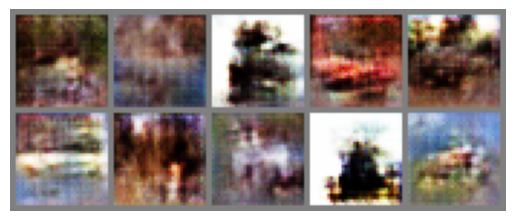

Epoch [10/50] | D Loss: 1.0630 | G Loss: 1.4766 | Real Loss: 0.6406 | Fake Loss: 0.4224 | FID Distance: 138.9685


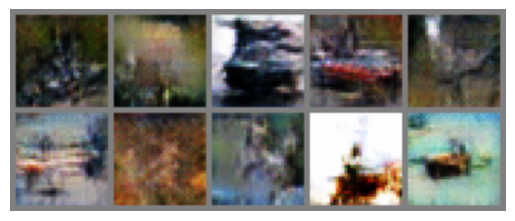

Epoch [15/50] | D Loss: 1.0524 | G Loss: 1.4325 | Real Loss: 0.6345 | Fake Loss: 0.4179 | FID Distance: 126.9499


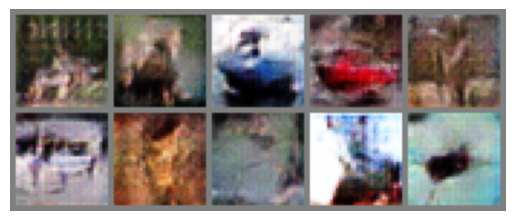

Epoch [20/50] | D Loss: 1.0282 | G Loss: 1.4803 | Real Loss: 0.6219 | Fake Loss: 0.4063 | FID Distance: 126.3667


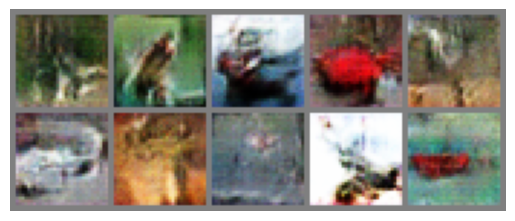

Epoch [25/50] | D Loss: 0.8979 | G Loss: 1.6682 | Real Loss: 0.5735 | Fake Loss: 0.3244 | FID Distance: 130.9054


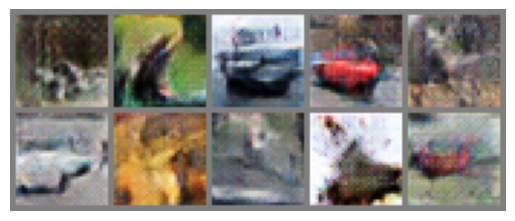

Epoch [30/50] | D Loss: 0.9754 | G Loss: 1.5975 | Real Loss: 0.5964 | Fake Loss: 0.3790 | FID Distance: 120.0380


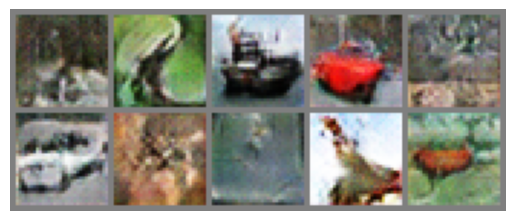

Epoch [35/50] | D Loss: 0.9527 | G Loss: 1.6154 | Real Loss: 0.5787 | Fake Loss: 0.3740 | FID Distance: 128.2587


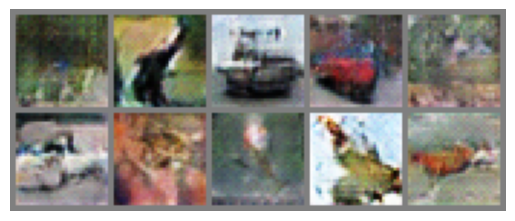

Epoch [40/50] | D Loss: 0.9075 | G Loss: 1.7351 | Real Loss: 0.5644 | Fake Loss: 0.3431 | FID Distance: 121.1957


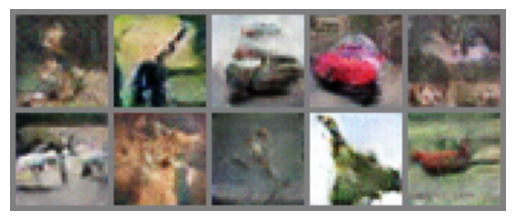

Epoch [45/50] | D Loss: 0.8833 | G Loss: 1.7762 | Real Loss: 0.5599 | Fake Loss: 0.3234 | FID Distance: 118.7474


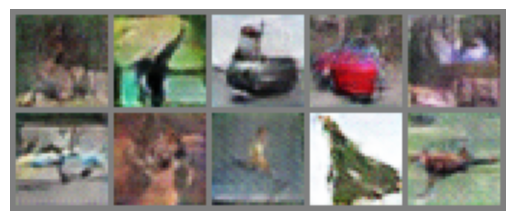

Epoch [50/50] | D Loss: 0.8945 | G Loss: 1.7736 | Real Loss: 0.5550 | Fake Loss: 0.3396 | FID Distance: 113.9782


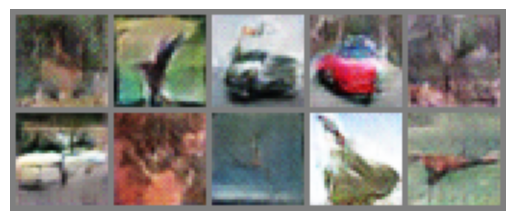

In [26]:
train_GAN(num_epochs, generator, discriminator, optimizer_G, optimizer_D, simple_logs, smoothing=True, d_rate=1, g_rate=1, random=False)

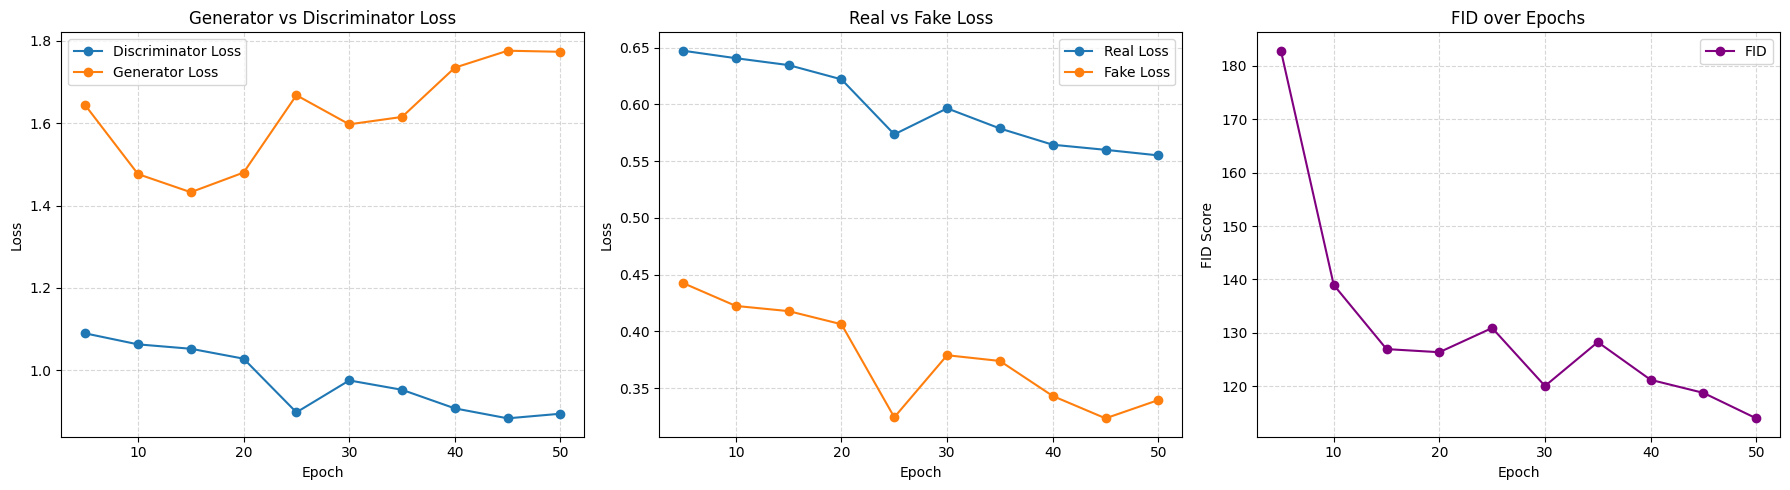

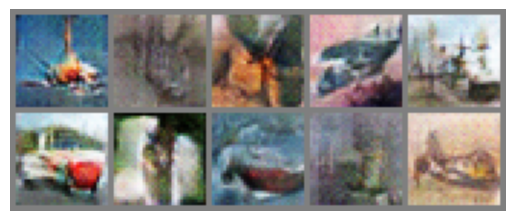

In [29]:
plot_gan_losses(simple_logs)
z_checking = torch.randn(viz_N, latent_dim, device=device)
with torch.no_grad():
    generated = generator(z_checking).detach().cpu()
    grid = torchvision.utils.make_grid(generated, nrow=5)
    grid = (grid + 1) / 2
    plt.imshow(np.transpose(grid, (1, 2, 0)))
    plt.axis("off")
    plt.show()

# Task 2: Analysing generations

- Inspect visual quality

- Use classifier to evaluate diversity of images. Use:
  def class_distribution(images):
  """
  images: torch.Tensor [B,3,H,W] in range [-1,1] (GAN output)
  returns: dict {class_name: count}
  """

- Use FID to evaluate fidelty of images. Use
  def calculate_fretchet(images_real,images_fake,model):


### Visual quality


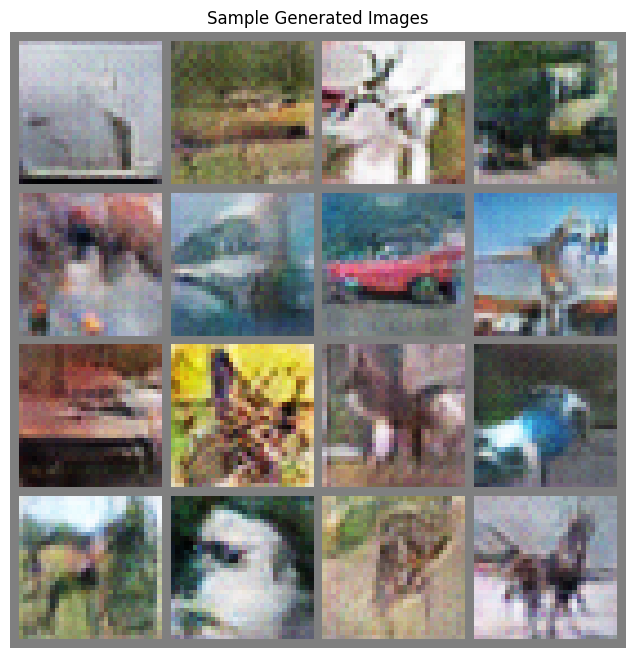

In [30]:
# Sample some generations and display them
z = torch.randn(16, latent_dim, device=device)
with torch.no_grad():
    generated = generator(z).cpu()

grid = torchvision.utils.make_grid(generated, nrow=4)
grid = (grid + 1) / 2 
plt.figure(figsize=(8, 8))
plt.imshow(np.transpose(grid, (1, 2, 0)))
plt.axis("off")
plt.title("Sample Generated Images")
plt.show()


### Diversity


In [31]:
# Generate 1k fake images and evaluate class distribution for mode collapse
z = torch.randn(1000, latent_dim, device=device)
with torch.no_grad():
    fake_images = generator(z).cpu()

dist = class_distribution(fake_images)
print("Class Distribution of Generated Images:")
for cls, count in dist.items():
    print(f"{cls}: {count}")

Class Distribution of Generated Images:
plane: 70
car: 34
bird: 136
cat: 101
deer: 159
dog: 21
frog: 278
horse: 34
ship: 127
truck: 40


### FID score


In [33]:
def get_n_images(dataloader, n, device):
    collected = []
    for imgs, _ in dataloader:
        collected.append(imgs.to(device))
        if sum(batch.size(0) for batch in collected) >= n:
            break
    return torch.cat(collected, dim=0)[:n]

real_images = get_n_images(testloader, 1000, device)

z = torch.randn(1000, latent_dim, device=device)
with torch.no_grad():
    fake_images = generator(z).to(device)


fid_scores = []
batch_size = 250
for i in range(4): 
    real_batch = real_images[i*batch_size:(i+1)*batch_size]
    fake_batch = fake_images[i*batch_size:(i+1)*batch_size]
    fid_score = calculate_fretchet(real_batch, fake_batch, model)
    fid_scores.append(fid_score)
    
print("FID Score: ", np.mean(fid_scores))

FID Score: 168.54804276942153


# Task 3: Latent Space exploration

- Interpolate between two random latent vectors z1 and z2 and comment on generations made from them


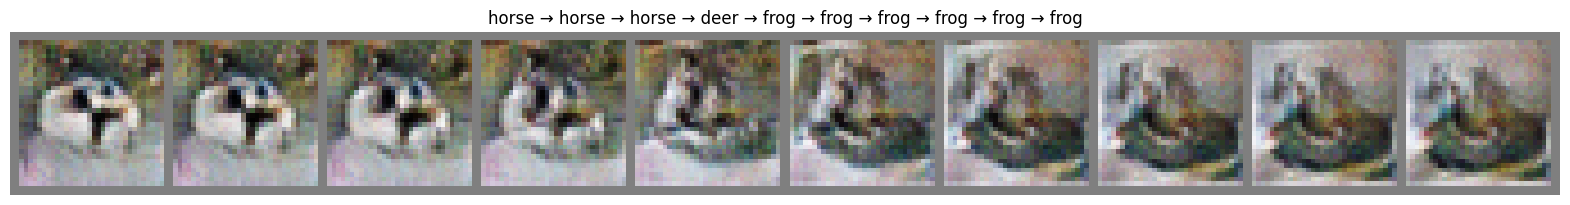

In [34]:
# Two random latent codes
z_1 = torch.randn(1, latent_dim, device=device)
z_2 = torch.randn(1, latent_dim, device=device)

# Interpolation factors
alphas = torch.linspace(0, 1, steps=10).to(device)

generated_images = []
labels = []

with torch.no_grad():
    for alpha in alphas:
        z = alpha * z_1 + (1 - alpha) * z_2
        gen = generator(z)  # shape [1,3,H,W]
        img = gen.squeeze(0).cpu()  # shape [3,H,W]
        generated_images.append(img)

        # Predict label
        label = predict_image((img + 1) / 2.0)  # convert [-1,1] → [0,1]
        labels.append(label)

# Plot interpolation row
grid = torchvision.utils.make_grid(generated_images, nrow=len(alphas))
grid = (grid + 1) / 2 
plt.figure(figsize=(20, 3))
plt.imshow(np.transpose(grid, (1, 2, 0)))
plt.axis("off")
plt.title(" → ".join(labels))
plt.show()


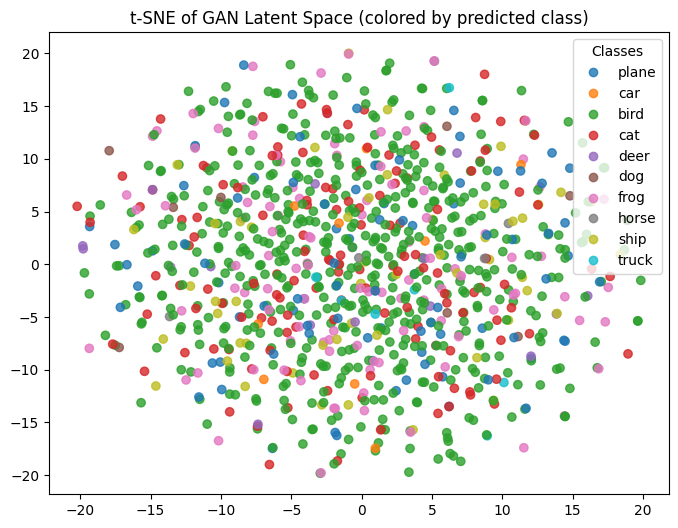

In [37]:
# 1. Sample latent vectors
z_samples = torch.randn(1000, latent_dim, device=device)

# 2. Generate images from your GAN
with torch.no_grad():
    gen_images = generator(z_samples).cpu()  # [500, 3, H, W]

# 3. Predict labels using your classifier
labels = [predict_image(img) for img in gen_images]  # list of class names

# 4. Map class names to integers for plotting
class_names = ['plane','car','bird','cat','deer','dog','frog','horse','ship','truck']
label_indices = np.array([class_names.index(l) for l in labels])

# 5. Run t-SNE on latent vector

z_pca = PCA(n_components=50).fit_transform(z_samples.cpu().numpy())
z_2d = TSNE(n_components=2, random_state=42).fit_transform(z_pca)

# 6. Plot
plt.figure(figsize=(8,6))
scatter = plt.scatter(z_2d[:,0], z_2d[:,1], c=label_indices, cmap='tab10', alpha=0.8)
plt.legend(handles=scatter.legend_elements()[0], labels=class_names, title="Classes")
plt.title("t-SNE of GAN Latent Space (colored by predicted class)")
plt.show()

# Task 4: OOD

- Scale latent vector so it is unlike the ones seen earlier, comment on generations made from these latent vectors


### really large


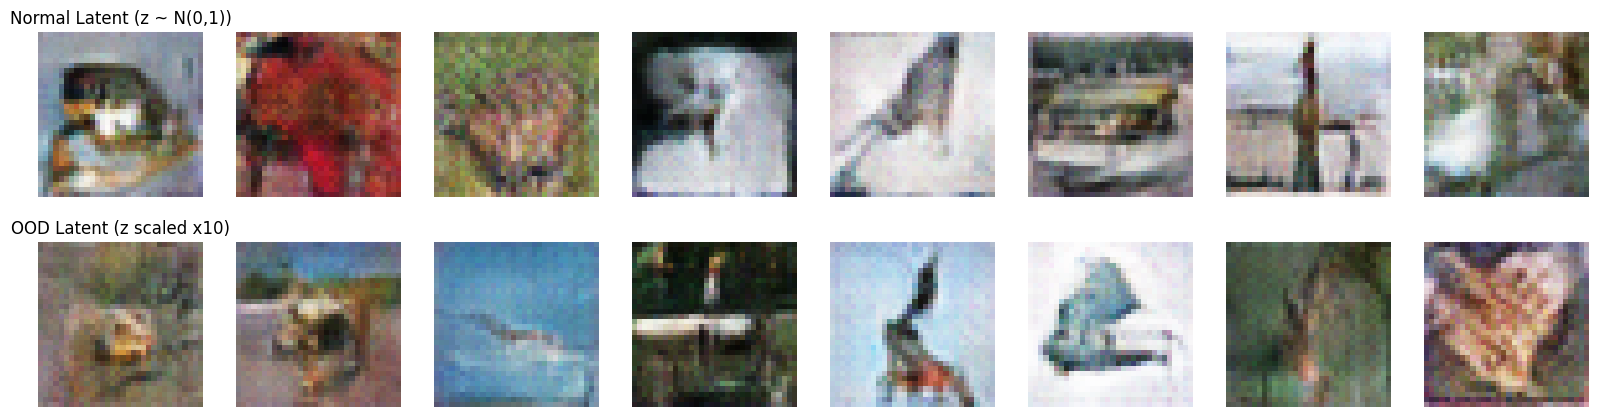

In [38]:
# Task 4: OOD Generations
# Scale latent vectors beyond training distribution
z_normal = torch.randn(16, latent_dim, device=device)         # normal latent
z_ood = 10 * torch.randn(16, latent_dim, device=device)        # scaled latent (OOD)

with torch.no_grad():
    normal_gen = generator(z_normal).detach().cpu()
    ood_gen = generator(z_ood).detach().cpu()

# Plot side-by-side for comparison
fig, axes = plt.subplots(2, 8, figsize=(20, 5))
for i in range(16):
    # Normal generations
    img_norm = (normal_gen[i] + 1) / 2 
    axes[0, i % 8].imshow(np.transpose(img_norm.numpy(), (1, 2, 0)))
    axes[0, i % 8].axis("off")

    # OOD generations
    ood_norm = (ood_gen[i] + 1) / 2 
    axes[1, i % 8].imshow(np.transpose(ood_norm.numpy(), (1, 2, 0)))
    axes[1, i % 8].axis("off")

axes[0, 0].set_title("Normal Latent (z ~ N(0,1))")
axes[1, 0].set_title("OOD Latent (z scaled x10)")
plt.show()